In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [4]:
def evaluateConstAct(x):
    config = {
        'action_reward_scale': np.array([0.08, 0.08, 0.4]),
        'max_action': 3000,
        # 'env_stoch': 0.,
        'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
        'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
        'traps_pmax': 10 * 2.75e-5, #2.75e-5,

        'loss_a': 0.2,
        'loss_b': 5,
        'loss_c': 5,
        
        'action_reward_exponent': 10,
    }
    env = greenCrabMonthEnv()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [5]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


2025-02-05 22:20:08,940	INFO worker.py:1841 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.8877
Function value obtained: 22.2524
Current minimum: 22.2524
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3355
Function value obtained: 39.7644
Current minimum: 22.2524
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3323
Function value obtained: 27.2134
Current minimum: 22.2524
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3325
Function value obtained: 43.0732
Current minimum: 22.2524
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3206
Function value obtained: 51.4685
Current minimum: 22.2524
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Ev

/opt/conda/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 0.0, 0.0] before, using random point [2569.359533125712, 126.80638163076354, 2888.2998904178708]
  warnings.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.4894
Function value obtained: 45.7070
Current minimum: 4.7051
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5621
Function value obtained: 1.3964
Current minimum: 1.3964
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5372
Function value obtained: 2.6566
Current minimum: 1.3964
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4968
Function value obtained: 2.8148
Current minimum: 1.3964
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5281
Function value obtained: 8.0070
Current minimum: 1.3964
Iteration No: 17 started. Se

[0.0, 155.98135282169312, 0.0]

In [7]:
# with nonNormalized env
evaluateConstAct(
    [0.0, 147.4919580663407, 0.0]
)

0.4939186493836216

In [8]:
import ray
ray.shutdown()

In [9]:
env = greenCrabMonthEnv()
agent = multiConstAction(env=env, action=np.array([0.0, 147.4919580663407, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,0.0,147.491958,0.0,0.000000,0
1,1,0.0,0.0,147.491958,0.0,-0.003994,0
2,2,0.0,0.0,147.491958,0.0,-0.007989,0
3,3,0.0,0.0,147.491958,0.0,-0.011983,0
4,4,0.0,0.0,147.491958,0.0,-0.015978,0


<Axes: xlabel='t'>

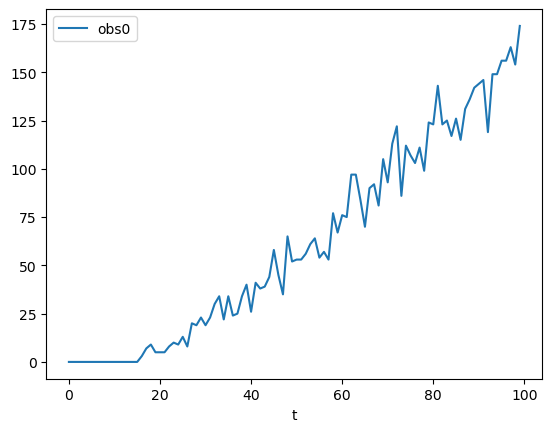

In [10]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [10]:
def environment_simulation(env, agent, reps=10, obs_names = None, acts_names = None):
    num_obs = np.prod(env.observation_space.shape)
    num_acts = np.prod(env.action_space.shape)
    obs_names = obs_names or [f'obs{i}' for i in range(num_obs)]
    acts_names = acts_names or [f'act{i}' for i in range(num_acts)]
    #
    data = {
        't': [],
        **{obsn: [] for obsn in obs_names},
        **{actn: [] for actn in acts_names},
        'rew': [],
        'rep': [],
        'crab_pop':[]
    }
    env = env
    agent = agent
    for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            #
            data['rew'].append(episode_reward)
            data['rep'].append(rep)
            data['t'].append(t)
            data['crab_pop'].append(env.state)
            for idx, obs_name in enumerate(obs_names):
                data[obs_name].append(observation[idx])
            for idx, act_name in enumerate(acts_names):
                data[act_name].append(action[idx])
            #
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            #
            if terminated or done:
                break
    return data

In [11]:
agent = multiConstAction(env=env, action=np.array([0, 0, 0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0,0,0,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0.0,0,0,0,-0.004501,0,"[462.36942053935, 1918.514818138611, 2435.3005..."
2,2,0.0,0,0,0,-0.010353,0,"[164.38442757217507, 957.5989437079668, 2030.8..."
3,3,0.0,0,0,0,-0.018296,0,"[60.712410449197165, 443.47663368747686, 1316...."
4,4,0.0,0,0,0,-0.029355,0,"[22.908515782991994, 201.30456075848102, 763.8..."


In [12]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df.head()

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,462.369421,1918.514818,2435.300511,1008.164157,271.609177,411.604666,660.150200,726.745419,608.932720,466.201594,...,307.551718,244.603720,191.889300,144.568102,101.232366,67.729716,42.759445,22.297432,7.101353,1
2,164.384428,957.598944,2030.868435,1837.689197,760.282842,365.614856,529.175272,684.774914,657.909530,529.328730,...,326.336381,263.393684,206.459219,153.582546,108.815433,73.811450,44.913909,23.498441,8.648786,2
3,60.712410,443.476634,1316.939798,1890.149206,1380.053528,627.307370,466.048227,607.844095,665.369732,583.515598,...,344.206183,282.817842,221.227660,164.191491,115.997674,78.883876,47.517994,24.743008,9.515905,3
4,22.908516,201.304561,763.804825,1509.951980,1650.204256,1060.236829,577.450085,546.390643,637.921260,616.212642,...,361.113874,302.513027,237.009472,178.158678,125.255927,85.129604,51.560315,25.707177,10.207567,4


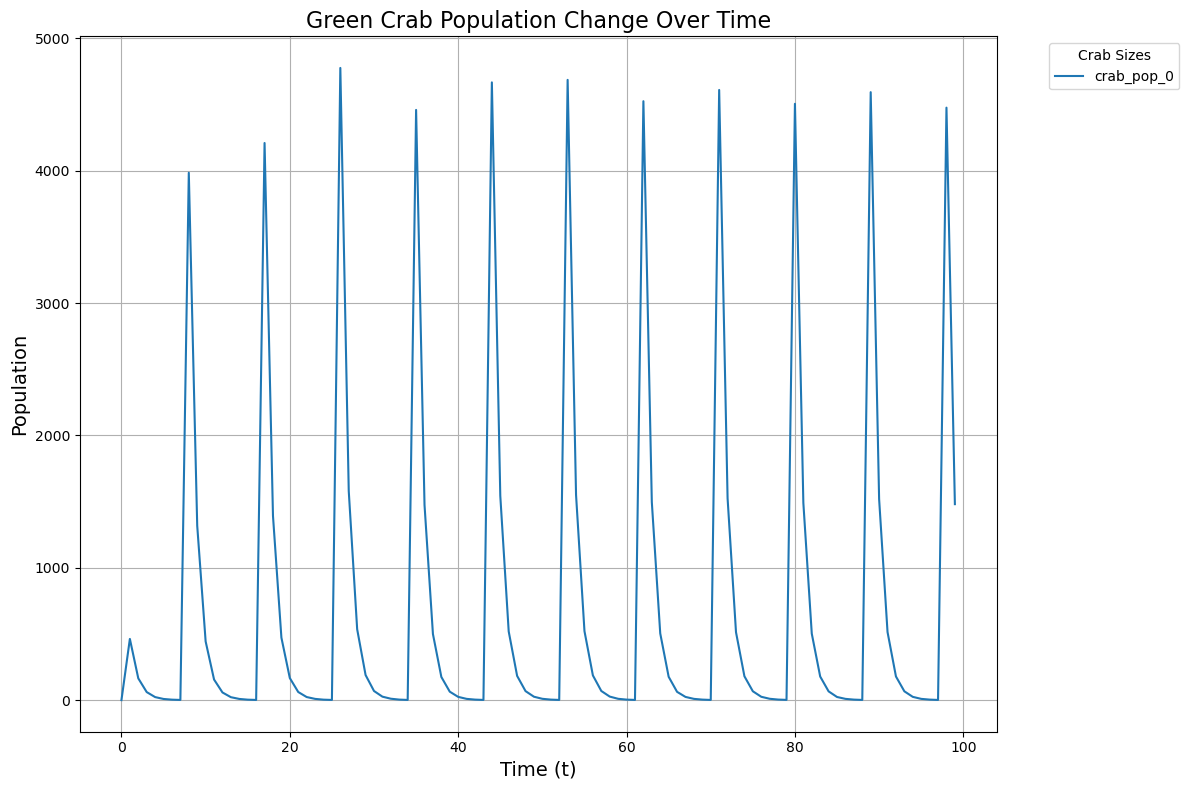

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

In [37]:
def plot_selected_sizes(expanded_df:pd.DataFrame, selected_sizes):
    plt.figure(figsize=(12, 8))
    time = expanded_df['t']  # Time column

    # If no sizes selected, show a placeholder message
    if not selected_sizes:
        plt.text(0.5, 0.5, 'No sizes selected', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.show()
        return

    # Plot each selected size
    for col in selected_sizes:
        plt.plot(time, expanded_df[col], label=col)

    # Customize the plot
    plt.title("Green Crab Population Change Over Time", fontsize=16)
    plt.xlabel("Time (t)", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.legend(title="Crab Sizes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

### normalized environment

In [14]:
env = greenCrabMonthEnvNormalized()
agent = multiConstAction(env=env, action=np.array([-0.22713126, -0.21056502, -0.16036674]))

In [15]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [16]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [17]:
normalized_action([0.0, 147.4919580663407, 0.0], max_action)

array([-1.        , -0.90167203, -1.        ])

In [18]:
evaluateConstAct([-1.        , -0.90167203, -1.        ])

2025-02-05 07:34:07,718	INFO worker.py:1841 -- Started a local Ray instance.


0.6891308119127361

In [19]:
import ray
ray.shutdown()

In [20]:
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-0.227131,-0.210565,-0.160367,0.00000,0
1,1,-1.0,-0.227131,-0.210565,-0.160367,-0.23048,0
2,2,-1.0,-0.227131,-0.210565,-0.160367,-0.46096,0
3,3,-1.0,-0.227131,-0.210565,-0.160367,-0.69144,0
4,4,-1.0,-0.227131,-0.210565,-0.160367,-0.92192,0


<Axes: xlabel='t'>

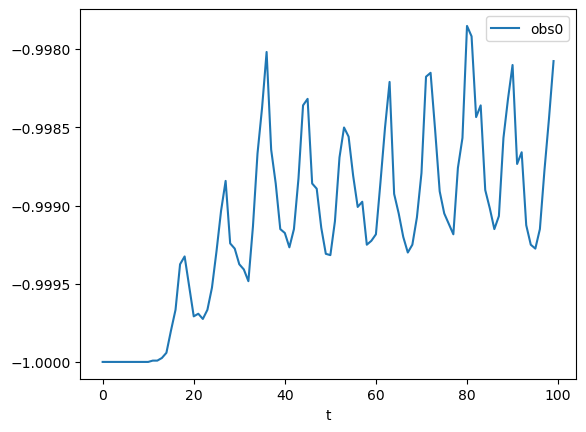

In [21]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [22]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [30]:
evalEnv = greenCrabMonthEnvNormalized()

In [39]:
td3Agent = TD3.load("TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [40]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-02-05 22:09:26,608	INFO worker.py:1841 -- Started a local Ray instance.


In [41]:
import ray
ray.shutdown()

In [42]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -11.570726360320029
TQC mean rew = -1.7654215731591956
TD3 mean rew = -1.32278359719714
RecurrentPPO mean rew = -2.0211408127946933



### RecurrentPPO plot

In [35]:
reppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_obs_acts()
reppoDataDF = pd.DataFrame(reppoData)
reppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.870507,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.870507,-1.0,-0.005241,0
2,2,-1.0,-1.0,-0.870507,-1.0,-0.010482,0
3,3,-1.0,-1.0,-0.870507,-1.0,-0.015723,0
4,4,-1.0,-1.0,-0.870507,-1.0,-0.020964,0


<Axes: xlabel='t'>

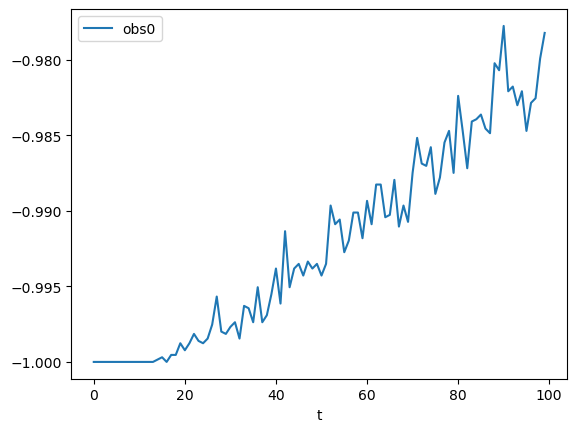

In [36]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['obs0'])